# Final Project - Churn forecast (churn risk estimation) 

Solution Code and Report submitted to the team leader: 

**Project Goal**:

Develop a model for churn risk esimation, of customers of the telecom operator Interconnect, in order to enable the company to offer at-risk customers promotional codes and special plan options. The model's primary metric is AUC-ROC, it must be above 0.75, preferably above 0.88

Please see below:

   **Solution Code and Report** 

**Executive Summary**: A model was developed, following preprocessing, that performed (on test set) AUC-ROC of 0.9367

## Data loading and initial pre-processing

### Data Loading and inspection

In [2]:
# Import libraries etc. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load the contract data into a df
contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [4]:
# load the personal data into a df
personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [5]:
# load the internet data into a df
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [6]:
# load the phone data into a df
phone = pd.read_csv('/datasets/final_provider/phone.csv')

We will now look at the **general info** and **head** of each data file - assuring no missing values and no duplicates

**contract**

(The contract information is valid as of February 1, 2020) 

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [9]:
# Since 'MonthlyCharges' are float (as expected of payment sum) - it is weird that 'TotalCharges' are a string, 
    # one reason might be that there are "hidden" missing values - let's look for them:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [10]:
# We see 11 customers with no 'TotalCharges', that are better dropped, 
    #since they just started the same day the data was retrived (February 1, 2020), 
    #and therfore have no real relevance for the churn question (our target)
contract = contract[contract['TotalCharges'] != ' ']
len(contract)

7032

In [11]:
# Checking for duplicates
contract.duplicated().sum()

0

**personal**

In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
# Checking for duplicates
personal.duplicated().sum()

0

**internet**

In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
# Checking for duplicates:
internet.duplicated().sum()

0

**phone**

In [18]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [20]:
# checking for duplicates:
phone.duplicated().sum()

0

Initial check of target (EndDate) class balance: 

In [21]:
contract[contract['EndDate'] == 'No']['customerID'].count() / contract['customerID'].count()

0.7342150170648464

Target class is imbalanced in ratio 3:1 (retention: churn). We will take this into consideration later by upsampling to balance the classes, although it is not a very severe imbalance. 


### Merging the data

We will first merge the 4 data files into one, and turn the 'customerID' into the index: 

In [22]:
# Merging the 4 files, and turning the customerID into the new index: 
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left').set_index('customerID', drop=True) 
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [23]:
# Checking general info of the unified df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7032 non-null   object 
 1   EndDate           7032 non-null   object 
 2   Type              7032 non-null   object 
 3   PaperlessBilling  7032 non-null   object 
 4   PaymentMethod     7032 non-null   object 
 5   MonthlyCharges    7032 non-null   float64
 6   TotalCharges      7032 non-null   object 
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   5512 non-null   object 
 12  OnlineSecurity    5512 non-null   object 
 13  OnlineBackup      5512 non-null   object 
 14  DeviceProtection  5512 non-null   object 
 15  TechSupport       5512 non-null   object 
 16  StreamingTV       5512 non-null 

### Filling in missing values in the unified data

In [24]:
# Filling in the NaNs (no phone or no internet) with 'No', and checking no NaNs are left
df = df.fillna('No')
df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

### Converting data types 

In [25]:
#df.astype(int) 
#df['column'].to_numeric()
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df.head()


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [26]:
# Change yes/no features into 0/1 
columns = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
          'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for column in columns:
    df[column] = df[column].replace({'Yes': 1, 'No': 0})
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,0
5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5,Male,0,0,0,DSL,1,0,1,0,0,0,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,0
7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0


In [27]:
# Convert 'TotalCharges' into float
df['TotalCharges'] = df['TotalCharges'].astype(float)

### Grouping churn customers' data

Before we convert our target (EndDate) into a binary 0/1 column - and in order not to lose the data about how much time it took customers to leave (those that did leave) - we will create another df (df1) with this data:
Later we will look at the distribution of the 'DaysToChurn'. It might be of value for the marketing team.

In [28]:
# Creating another df, only of 'churn' customers, with the time it took them to leave:
df1 = df[df['EndDate'] != 'No'] 
df1['EndDate'] = pd.to_datetime(df1['EndDate']) 
df1['DaysToChurn'] = df1['EndDate'] - df1['BeginDate']
df1.head() 

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DaysToChurn
customerID,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,0,61 days
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0,61 days
9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,Female,0,0,0,Fiber optic,0,0,1,0,1,1,1,245 days
7892-POOKP,2017-07-01,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,Female,0,1,0,Fiber optic,0,0,1,1,1,1,1,853 days
0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,1,Bank transfer (automatic),103.70,5036.30,Male,0,0,0,Fiber optic,0,1,1,0,1,1,1,1491 days


In [29]:
# Turn 'EndDate' (our target) in df into a 0/1 column
df.loc[(df['EndDate'] != 'No'), 'EndDate'] = 'Yes'
df['EndDate'] = df['EndDate'].replace({'Yes': 1, 'No': 0})
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,0,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,0
5575-GNVDE,2017-04-01,0,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,0
3668-QPYBK,2019-10-01,1,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,0
7795-CFOCW,2016-05-01,0,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,0
9237-HQITU,2019-09-01,1,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0


In [30]:
# Checking all datatypes are OK to continue:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   int64         
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   int64         
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7032 non-null   object        
 8   SeniorCitizen     7032 non-null   int64         
 9   Partner           7032 non-null   int64         
 10  Dependents        7032 non-null   int64         
 11  InternetService   7032 non-null   object        
 12  OnlineSecurity    7032 non-null   int64         
 13  OnlineBackup      7032 non-null   int64         
 14  DeviceProtecti

## EDA

### BeginDate and EndDate 

In [31]:
# Look at the timespan of BeginDate (after we removed the few customers with BeginDate in same day of data retrieval)
df['BeginDate'].describe()

count                    7032
unique                     76
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-01-01 00:00:00
Name: BeginDate, dtype: object

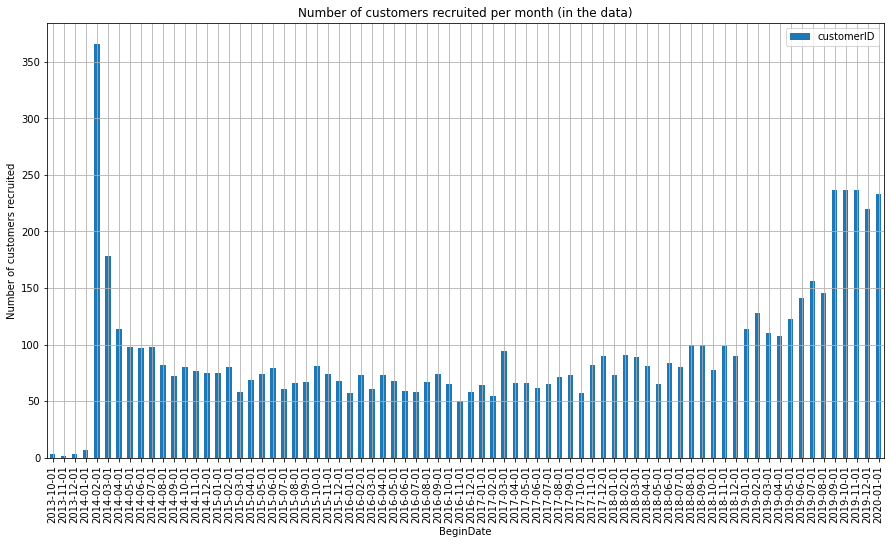

In [32]:
# How many customers recruited every month (in the data)
customers_per_BeginMonth = contract.pivot_table(index='BeginDate', values='customerID', aggfunc='count')
customers_per_BeginMonth.plot(kind='bar', grid=True, figsize=(15, 8))
plt.title('Number of customers recruited per month (in the data)')
plt.ylabel('Number of customers recruited')
plt.show;

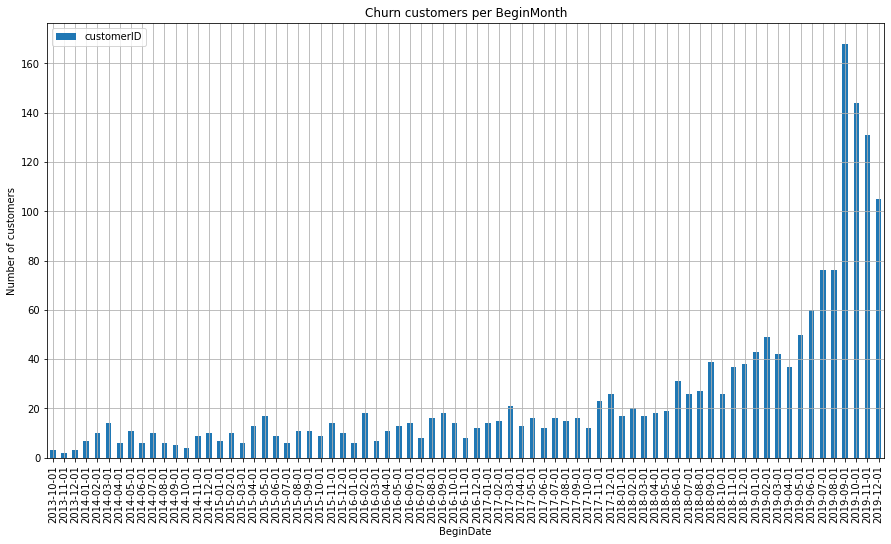

In [33]:
# Churn customers per their BeginMonth: 
contract_churn = contract[contract['EndDate'] != 'No']
Churn_cust_per_BeginMonth = contract_churn.pivot_table(
    index='BeginDate', values='customerID', aggfunc='count')
Churn_cust_per_BeginMonth.plot(kind='bar', grid=True, figsize=(15, 8))
plt.title('Churn customers per BeginMonth')
plt.ylabel('Number of customers')
plt.show;

In [34]:
# Following the observations above - it is clear the month+year of BeginDate might carry an important signal for churn
    #and therfore we will create 2 numeric features out of this data:
df['MonthBegin'] = df['BeginDate'].dt.month
df['YearBegin'] = df['BeginDate'].dt.year
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,MonthBegin,YearBegin
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,0,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,...,DSL,0,1,0,0,0,0,0,1,2020
5575-GNVDE,2017-04-01,0,One year,0,Mailed check,56.95,1889.50,Male,0,0,...,DSL,1,0,1,0,0,0,0,4,2017
3668-QPYBK,2019-10-01,1,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,...,DSL,1,1,0,0,0,0,0,10,2019
7795-CFOCW,2016-05-01,0,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,...,DSL,1,0,1,1,0,0,0,5,2016
9237-HQITU,2019-09-01,1,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,...,Fiber optic,0,0,0,0,0,0,0,9,2019


In [35]:
# Look at the timespan of EndDate for those that left
df1['EndDate'].describe()

count                    1869
unique                      4
top       2019-11-01 00:00:00
freq                      485
first     2019-10-01 00:00:00
last      2020-01-01 00:00:00
Name: EndDate, dtype: object

In [36]:
# How many left in each date 
df1['EndDate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

### Monthly Charges

In [37]:
# general statistics of monthly charges
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

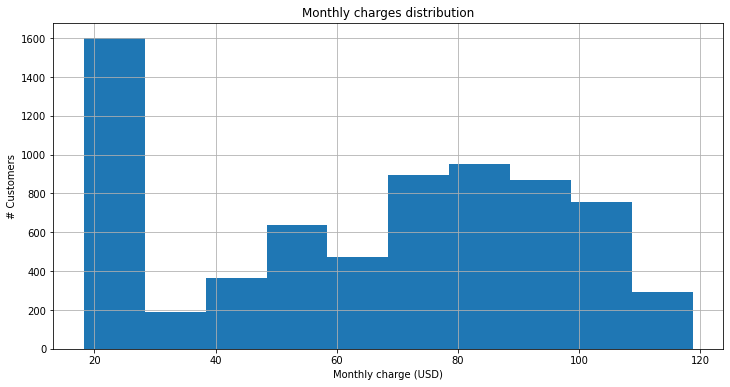

In [38]:
# Histogram of MonthlyCharges distribution: 
plt.figure(figsize=(12, 6))
df['MonthlyCharges'].hist(grid=True)
plt.title('Monthly charges distribution')
plt.xlabel('Monthly charge (USD)')
plt.ylabel('# Customers')
#plt.legend(['Feed', 'Rougher', 'Primary cleaner', 'Final'])
plt.show;

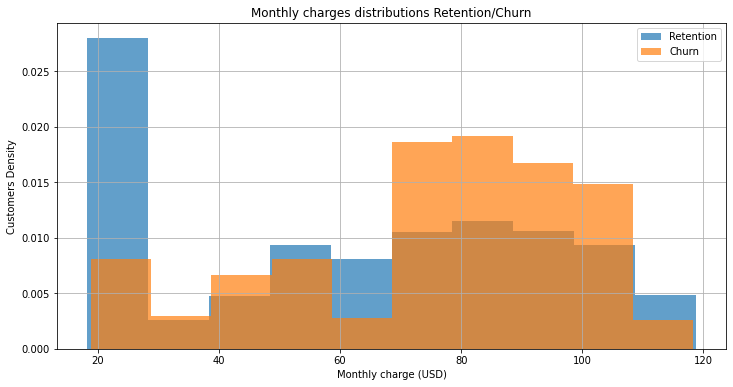

In [39]:
# Histograms of monthly charges distributions by Churn/Retention: 
plt.figure(figsize=(12, 6))
df[df['EndDate'] == 0]['MonthlyCharges'].hist(density=True, grid=True, alpha=0.7)
df[df['EndDate'] == 1]['MonthlyCharges'].hist(density=True, alpha=0.7) 
plt.title('Monthly charges distributions Retention/Churn')
plt.xlabel('Monthly charge (USD)')
plt.ylabel('Customers Density')
plt.legend(['Retention', 'Churn'])
plt.show;

The difference in distributions clearly shows that 'MonthlyCharges' might carry siganl about chance to churn.

### In search of other trends / significant features 

In [40]:
# Looking for correlation between the numeric columns and the target
df.corr()    

,EndDate,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,MonthBegin,YearBegin
EndDate,1.000000,0.191454,0.192858,-0.199484,0.150541,-0.149982,-0.163128,-0.171270,-0.082307,-0.066193,-0.164716,0.063254,0.060860,0.040033,0.180522,0.293770
PaperlessBilling,0.191454,1.000000,0.351930,0.157830,0.156258,-0.013957,-0.110131,-0.004051,0.127056,0.104079,0.037536,0.224241,0.211583,0.163746,0.022846,-0.017451
MonthlyCharges,0.192858,0.351930,1.000000,0.651065,0.219874,0.097825,-0.112343,0.296447,0.441529,0.482607,0.338301,0.629668,0.627235,0.490912,-0.019613,-0.263086
TotalCharges,-0.199484,0.157830,0.651065,1.000000,0.102411,0.319072,0.064653,0.412619,0.510100,0.522881,0.432868,0.515709,0.519867,0.469042,-0.196624,-0.819304
SeniorCitizen,0.150541,0.156258,0.219874,0.102411,1.000000,0.016957,-0.210550,-0.038576,0.066663,0.059514,-0.060577,0.105445,0.119842,0.142996,0.028569,-0.027386
Partner,-0.149982,-0.013957,0.097825,0.319072,0.016957,1.000000,0.452269,0.143346,0.141849,0.153556,0.120206,0.124483,0.118108,0.142561,-0.130636,-0.370110
Dependents,-0.163128,-0.110131,-0.112343,0.064653,-0.210550,0.452269,1.000000,0.080786,0.023639,0.013900,0.063053,-0.016499,-0.038375,-0.024307,-0.065231,-0.152367
OnlineSecurity,-0.171270,-0.004051,0.296447,0.412619,-0.038576,0.143346,0.080786,1.000000,0.283285,0.274875,0.354458,0.175514,0.187426,0.098592,-0.103832,-0.317782
OnlineBackup,-0.082307,0.127056,0.441529,0.510100,0.066663,0.141849,0.023639,0.283285,1.000000,0.303058,0.293705,0.281601,0.274523,0.202228,-0.073722,-0.360242
DeviceProtection,-0.066193,0.104079,0.482607,0.522881,0.059514,0.153556,0.013900,0.274875,0.303058,1.000000,0.332850,0.389924,0.402309,0.201733,-0.092690,-0.358494


In [41]:
# Combine YearBegin and MonthBegin into one string feature (to be encoded later)
df['StrBegin'] = df['YearBegin'].astype(str) + df['MonthBegin'].astype(str)

In [42]:
# Lookig for possible churn trends by 'Type' value
df.pivot_table(index='Type', values='EndDate', aggfunc='mean')

,EndDate
Type,
Month-to-month,0.427097
One year,0.112772
Two year,0.028487


Month-to-Month has a higher chance for churn than the other Types 

In [43]:
# Lookig for possible churn trends by 'PaymentMethod' value
df.pivot_table(index='PaymentMethod', values='EndDate', aggfunc='mean')

,EndDate
PaymentMethod,
Bank transfer (automatic),0.167315
Credit card (automatic),0.152531
Electronic check,0.452854
Mailed check,0.192020


Electronic check has a higher chance to churn than the other Payment Methods

In [44]:
# Lookig for possible churn trends by 'gender' value
df.pivot_table(index='gender', values='EndDate', aggfunc='mean')

,EndDate
gender,
Female,0.269595
Male,0.262046


No observed gender difference in chance to churn. We will consider this observation for feature selection. 

In [45]:
# Lookig for possible churn trends by 'InternetService' value
df.pivot_table(index='InternetService', values='EndDate', aggfunc='mean')

,EndDate
InternetService,
DSL,0.189983
Fiber optic,0.418928
No,0.074342


Fiber optic has higher chance to churn than DSL or no internet. Following the above observations about the 4 categorical features (that have no natural ordinal meaning)- we will prefer to use below some kind of target encoding. 

In [46]:
# looking at the list of columns
df.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'MonthBegin', 'YearBegin', 'StrBegin'],
      dtype='object')

In [47]:
# Lookig for possible churn trends in the 0/1 features - to help with feature selection
columns = ['PaperlessBilling', 'SeniorCitizen', 'Partner',
       'Dependents', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies', 'MultipleLines']
for column in columns:
    print(df.pivot_table(index=column, values='EndDate', aggfunc='mean'))
    print()

                   EndDate
PaperlessBilling          
0                 0.163757
1                 0.335893

                EndDate
SeniorCitizen          
0              0.236503
1              0.416813

          EndDate
Partner          
0        0.329761
1        0.197171

             EndDate
Dependents          
0           0.312791
1           0.155312

                 EndDate
OnlineSecurity          
0               0.313733
1               0.146402

               EndDate
OnlineBackup          
0             0.292164
1             0.215670

                   EndDate
DeviceProtection          
0                 0.286953
1                 0.225393

              EndDate
TechSupport          
0            0.312300
1            0.151961

              EndDate
StreamingTV          
0            0.243705
1            0.301147

                  EndDate
StreamingMovies          
0                0.244362
1                0.299524

                EndDate
MultipleLines          
0 

Some features seem to be with less difference (between their 0/1) in the chance for churn. We will consider droping these fetures during feature selection.
These are: 'MultipleLines', 'StreamingMovies', 'StreamingTV', 'DeviceProtection', 'OnlineBackup'.

The other 0/1 features have significant difference (between their 0/1) in the chance for churn, so they might be valueable for our model development.  

### Statistics and distribution of time-to-churn (of churn customers)

Before moving to feature preprocessing - we will finish EDA with a look into the statistics and distribution of the time it took customers to leave (for those that left). This analysis might be usefull for the marketing team. 

In [48]:
# General statistics of DaysToChurn (among churn customers)
df1['DaysToChurn'].describe()

count                           1869
mean     547 days 08:26:57.977528088
std      594 days 09:21:02.012639248
min                 30 days 00:00:00
25%                 61 days 00:00:00
50%                304 days 00:00:00
75%                883 days 00:00:00
max               2191 days 00:00:00
Name: DaysToChurn, dtype: object

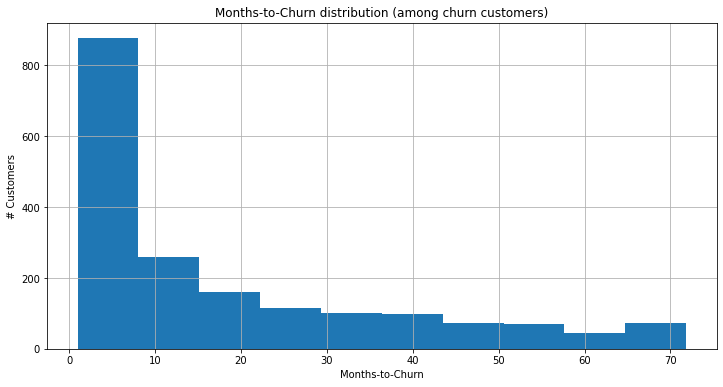

In [49]:
# Months-to-Churn distribution (among churn customers)
plt.figure(figsize=(12, 6))
(df1['DaysToChurn'].astype('timedelta64[h]') / (24*30.5)).hist(grid=True)
plt.title('Months-to-Churn distribution (among churn customers)')
plt.xlabel('Months-to-Churn')
plt.ylabel('# Customers')
plt.show;

## Feature Preprocessing

In [50]:
# Encoding the categorical features and standardizing all features, after splitting into train-valid-test sets and upsampling
!pip install category_encoders
from sklearn.utils import shuffle
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler

encoder = CatBoostEncoder()
X = df.drop(['EndDate', 'BeginDate', 'gender', 'MultipleLines', 'StreamingMovies', 'StreamingTV',
             'DeviceProtection', 'OnlineBackup'], axis=1)
y = df['EndDate']

# In the first step of splitting we will split the data into "seen" (to be split later to train and validation) and  test set
X_seen, X_test, y_seen, y_test = train_test_split(X,y, train_size=0.8, random_state=12345)

# Now since we want to split the "seen" set into train (60% of all data, 75% of the seen data) 
    # and validation set (20% of all data, 25% of the seen data)
X_train, X_valid, y_train, y_valid = train_test_split(X_seen, y_seen, test_size=0.25, random_state=12345)

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


X_train, y_train = upsample(
    X_train, y_train, 3
)

X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


## Model Training 

In [51]:
# Function to train, predict, and evaluate a model:
import sklearn.metrics as metrics
def model_TPE (X_train, y_train, X_eval, y_eval, model):
    model.fit(X_train, y_train)
    pred_eval = model.predict(X_eval)
    pred_proba = model.predict_proba(X_eval)[:, 1]
    print(model, 'AUC-ROC', metrics.roc_auc_score(y_eval, pred_proba))
    print(model, 'F1', metrics.f1_score(y_eval, pred_eval))

### Training on train set and evaluationg on validation set

In [52]:
# Dummy model as baseline
from sklearn.dummy import DummyClassifier
model = DummyClassifier()
model_TPE(X_train, y_train, X_valid, y_valid, model)

DummyClassifier() AUC-ROC 0.5
DummyClassifier() F1 0.42352941176470593


In [53]:
# Decision tree classifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model_TPE(X_train, y_train, X_valid, y_valid, model)

DecisionTreeClassifier() AUC-ROC 0.7637404168016413
DecisionTreeClassifier() F1 0.647571606475716


In [54]:
# Logistic regression 
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=12345, solver='liblinear')
model_TPE(X_train, y_train, X_valid, y_valid, model)

LogisticRegression(random_state=12345, solver='liblinear') AUC-ROC 0.8589528025873994
LogisticRegression(random_state=12345, solver='liblinear') F1 0.6475409836065573


In [55]:
# LightGBM Classifier with hyperparameters tuning
%%time
import lightgbm as lgbm
print('On validation set:')
num_leaves_list = [30, 50, 100]
max_depth_list = [0, 5, 8]
n_estimators_list = [10, 50, 100]
for n in num_leaves_list:
    for m in max_depth_list:
        for e in n_estimators_list:
            model = lgbm.LGBMClassifier(num_leaves=n, max_depth=m, n_estimators=e)
            model_TPE(X_train, y_train, X_valid, y_valid, model)
            print()


On validation set:
LGBMClassifier(max_depth=0, n_estimators=10, num_leaves=30) AUC-ROC 0.8829268668918815
LGBMClassifier(max_depth=0, n_estimators=10, num_leaves=30) F1 0.6740088105726872

LGBMClassifier(max_depth=0, n_estimators=50, num_leaves=30) AUC-ROC 0.9014325306842313
LGBMClassifier(max_depth=0, n_estimators=50, num_leaves=30) F1 0.7093821510297483

LGBMClassifier(max_depth=0, num_leaves=30) AUC-ROC 0.9118602845522183
LGBMClassifier(max_depth=0, num_leaves=30) F1 0.7240143369175627

LGBMClassifier(max_depth=5, n_estimators=10, num_leaves=30) AUC-ROC 0.8684807256235827
LGBMClassifier(max_depth=5, n_estimators=10, num_leaves=30) F1 0.6520833333333333

LGBMClassifier(max_depth=5, n_estimators=50, num_leaves=30) AUC-ROC 0.8905240100575378
LGBMClassifier(max_depth=5, n_estimators=50, num_leaves=30) F1 0.6802575107296137

LGBMClassifier(max_depth=5, num_leaves=30) AUC-ROC 0.9042310045711406
LGBMClassifier(max_depth=5, num_leaves=30) F1 0.6998867497168744

LGBMClassifier(max_depth=8, n

Best AUC-ROC from LGBMClassifier on valid set is 0.913, and it was achieved with LGBMClassifier(max_depth=0, num_leaves=50) and the default n_estimators=100. This model's F1_score on the valid set is 0.746

In [56]:
# CatBoost classifier
from catboost import CatBoostClassifier

model = CatBoostClassifier(eval_metric='AUC', verbose=100)
model.fit(X_train, y_train,eval_set=(X_valid, y_valid), use_best_model=True)

Learning rate set to 0.050188
0:	test: 0.8464092	best: 0.8464092 (0)	total: 53.2ms	remaining: 53.2s
100:	test: 0.8909919	best: 0.8910202 (99)	total: 507ms	remaining: 4.51s
200:	test: 0.9020547	best: 0.9020984 (199)	total: 959ms	remaining: 3.81s
300:	test: 0.9093716	best: 0.9093716 (300)	total: 1.38s	remaining: 3.19s
400:	test: 0.9132794	best: 0.9132794 (400)	total: 1.78s	remaining: 2.66s
500:	test: 0.9150920	best: 0.9153979 (482)	total: 2.19s	remaining: 2.18s
600:	test: 0.9175318	best: 0.9179174 (592)	total: 2.67s	remaining: 1.77s
700:	test: 0.9176269	best: 0.9181077 (683)	total: 3.16s	remaining: 1.35s
800:	test: 0.9186630	best: 0.9187607 (774)	total: 3.65s	remaining: 908ms
900:	test: 0.9195988	best: 0.9196194 (899)	total: 4.16s	remaining: 457ms
999:	test: 0.9202827	best: 0.9202878 (995)	total: 4.61s	remaining: 0us

bestTest = 0.920287843
bestIteration = 995

Shrink model to first 996 iterations.


In [57]:
# CatBoost classifier with hyperparameter tuning
depth_list = [4, 6, 8, 10]
lr_list = [0.01, 0.05, 0.08]
leaf_reg_list = [2, 3, 4]
for d in depth_list:
    for lr in lr_list:
        for l in leaf_reg_list:
            print('tree depth=', d, 'learning_rate=', lr, 'l2_leaf_reg=', l) 
            model = CatBoostClassifier(depth=d, learning_rate=lr, l2_leaf_reg=l, eval_metric='AUC', verbose=100)
            model.fit(X_train, y_train,eval_set=(X_valid, y_valid), use_best_model=True)

tree depth= 4 learning_rate= 0.01 l2_leaf_reg= 2
0:	test: 0.8239455	best: 0.8239455 (0)	total: 2.29ms	remaining: 2.29s
100:	test: 0.8596521	best: 0.8596932 (98)	total: 257ms	remaining: 2.28s
200:	test: 0.8679125	best: 0.8679125 (200)	total: 515ms	remaining: 2.05s
300:	test: 0.8748001	best: 0.8748001 (300)	total: 788ms	remaining: 1.83s
400:	test: 0.8798032	best: 0.8798032 (400)	total: 1.03s	remaining: 1.54s
500:	test: 0.8839475	best: 0.8839475 (500)	total: 1.28s	remaining: 1.27s
600:	test: 0.8869195	best: 0.8869195 (600)	total: 1.52s	remaining: 1.01s
700:	test: 0.8893825	best: 0.8893825 (700)	total: 1.76s	remaining: 750ms
800:	test: 0.8914496	best: 0.8914521 (799)	total: 2.01s	remaining: 500ms
900:	test: 0.8935474	best: 0.8935474 (900)	total: 2.26s	remaining: 248ms
999:	test: 0.8951414	best: 0.8951414 (999)	total: 2.53s	remaining: 0us

bestTest = 0.8951414277
bestIteration = 999

tree depth= 4 learning_rate= 0.01 l2_leaf_reg= 3
0:	test: 0.8239455	best: 0.8239455 (0)	total: 3.08ms	remain

Best CatBoostClassifier AUC-ROC on the valid set is 0.926, with depth= 4, learning_rate= 0.08, l2_leaf_reg= 2, and with the first 985 iterations

### Final model training on train+valid sets

The 2 models we will prepare for testing are the 2 best ones (by AUC-ROC) - one of each boosting algorithm

In [58]:
# Upsampling, Encoding and standardizing for train+valid (the "seen" data)

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


X_seen, y_seen = upsample(
    X_seen, y_seen, 3
)


#encoder = CatBoostEncoder()
X_seen = encoder.transform(X_seen, y_seen)
#X_test = encoder.transform(X_test)

#scaler = StandardScaler()
X_seen = scaler.transform(X_seen)
#X_test = scaler.transform(X_test)


## Model Testing

In [59]:
# The best LGBMClassifier
model = lgbm.LGBMClassifier(max_depth=0, num_leaves=50)
model_TPE(X_seen, y_seen, X_test, y_test, model)


LGBMClassifier(max_depth=0, num_leaves=50) AUC-ROC 0.9226322821475197
LGBMClassifier(max_depth=0, num_leaves=50) F1 0.742561448900388


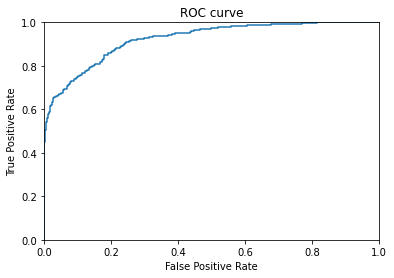

In [61]:
# For the testing we will add the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [62]:
# The best CatBoostClassifier
model = CatBoostClassifier(depth=4, learning_rate= 0.08, l2_leaf_reg= 2, iterations=985, eval_metric='AUC', verbose=100)
model_TPE(X_seen, y_seen, X_test, y_test, model)

0:	total: 3.65ms	remaining: 3.59s
100:	total: 289ms	remaining: 2.52s
200:	total: 569ms	remaining: 2.22s
300:	total: 846ms	remaining: 1.92s
400:	total: 1.14s	remaining: 1.65s
500:	total: 1.44s	remaining: 1.39s
600:	total: 1.72s	remaining: 1.1s
700:	total: 1.98s	remaining: 803ms
800:	total: 2.24s	remaining: 515ms
900:	total: 2.49s	remaining: 232ms
984:	total: 2.73s	remaining: 0us
<catboost.core.CatBoostClassifier object at 0x7f5c466ca400> AUC-ROC 0.9366534758485638
<catboost.core.CatBoostClassifier object at 0x7f5c466ca400> F1 0.7744360902255638


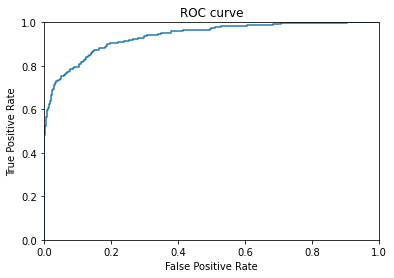

In [63]:
# ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Conclusions

Both LightGBM Classifier and CatBoostClassifier models have performed with AUC-ROC above 0.92 (high quality by assesment criteria) on the test set. Best AUC-ROC is 0.93665, with F1 score of 0.77, and it was achieved by the following model:  CatBoostClassifier(depth=4, learning_rate= 0.08, l2_leaf_reg= 2, iterations=985, eval_metric='AUC', verbose=100). 

## Report 

This report includes answers to four defined questions:

### What steps of the plan were performed and what steps were skipped (explain why)?

All steps of the plan were performed, and some steps were added to the approved plan (like final training of the 2 final best models, after hyperparameters tuning, on the combined train+valid dataset (all "seen" data) before testing them on the test set). Some feature creation steps were included in the EDA - following the findings.

Since the 2 boosting algorithms performed much better than the simpler models, the hyperparameters tuning and final testing focused on these two algorithms.

Following the team-lead's instruction for a more rounded evaluation and another metric in addition to AUC-ROC, F1 was calculated as well, and for the final testing of the 2 best models (one of each boosting algorithm that was used) - the ROC curve was plotted. The final upgraded structure was:  

1. Data Initial Preparation
    - Data loading, inspection and merging
    - Fill in nans 
    - Check for duplicates
    - Convert datatypes
    
    
2. EDA 
    - Check for impossible (mistake) values
    - Try to identify trends
    - Some feature creation (according to findings)
    
    
3. Feature Preprocessing
    - Train-valid-test split (60:20:20)
    - Feature selection (trying to select highest-signal features)
    - Dealing with class imbalance 
    - Encoding categorical features
    - Scaling-normalizing all features (now all numerical)
   
   
4. Model Training
    - Try a few classification algorithms, with hyperparameters tuning
    - Choose from each of the 2 best algorithms (by AUC-ROC) the best option, while cheking F1 score as well
    - Final training of the 2 best models (one from each boosting algorithm) on the combined train+valid data set (after upsampling, encoding and scaling it) 
    
    
5. Model Testing
    - Test the best model of each of the 2 top algorithms on the test set (+checking F1 score as well, and plotting ROC curve) 
    - Find the best model (by AUC-ROC) 
    
    
6. Conclusions 


### What difficulties did you encounter and how did you manage to solve them?

1. When I wanted to turn the target ('EndDate') into a binary 0/1 column, I didn't want to lose the data (important for EDA in my eyes) about the date of churn, for those that left the company. My solution was to first create another df, only of churn customers (so there the cloumn can be turned into DateTime), and analyze their 'TimeToChurn', and only than to convert 'EndDate' in the main df (for the model) to 0/1 binary target. 


2. When I found out that the month and year of BeginDate carry important signal about chances to churn, I wanted to keep this signal in one feature (and not just in dt.month and dt.year, which carry much less signal separately). After consulting with tutors, I eventually created a string feature of the month and year together, and encoded it with the same target encoder that I chose for all the categorical features. Results improved following this change. 


3. When I tried first to upsample the train data after the encoding and scaling, It gave an error bacause I used "concat" and now it was np.array. My solution was to upsample in the same way, just before the encoding and the scaling.



### What were some of the key steps to solving the task?

1. I belive the feature creation and selection, based on findings of the EDA and signal-searching, was an important key.


2. All the steps mentioned in the former question were keys for improvement.


3. The consultation with team-lead, and other tutors, was very helpful and productive.



### What is your final model and what quality score does it have?

My final model (after feature selection, upsampling, encoding and scaling) is:
CatBoostClassifier(depth=4, learning_rate= 0.08, l2_leaf_reg= 2, iterations=985, eval_metric='AUC', verbose=100). 
On the test set it's AUC-ROC is 0.9367, and the F1 score is 0.77 